# K-means segmentation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

from pyspark.ml.clustering import KMeans
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

import helper as h

In [2]:
_data = h.get_merged_data('k-means', year='2016')

_data.head()

% of users dropped 4.698526359485271


Row(login='0loky0', followers_count=0, following_count=1, blog=0, company=0, created_at=datetime.datetime(2011, 5, 24, 16, 15, 25), public_repos_count=7, public_gists_count=0, hireable=1, recency=1788, updated_at=datetime.datetime(2019, 1, 9, 10, 3, 59), time_between_first_last_event=11, last_event=datetime.datetime(2016, 4, 15, 6, 14, 3), first_event=datetime.datetime(2016, 4, 4, 14, 44, 57), frequency=19, second_period_event_count=0, CommitCommentEvent_count=0, CreateEvent_count=5, DeleteEvent_count=0, ForkEvent_count=2, GollumEvent_count=0, IssueCommentEvent_count=0, IssuesEvent_count=0, MemberEvent_count=0, PublicEvent_count=0, PullRequestEvent_count=0, PullRequestReviewCommentEvent_count=0, PushEvent_count=12, ReleaseEvent_count=0, WatchEvent_count=0)

In [3]:
churn_data = _data.filter(_data.company == 0) 

## Create new features

1. Active events.
2. Public repos and gists

Take the log of each of these.

In [4]:
churn_data = h.create_KMeans_features(churn_data)

In [5]:
churn_data.select(['non_passive_events', 'public_repos_gists']).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
non_passive_events,141935,2.093527523916786,1.1419054704348273,0.0,5.298317366548036
public_repos_gists,141935,2.519910756023042,1.2686131067841777,1.0,8.69575799055476


In [ ]:
churn_data.head()

In [7]:
# Trains a k-means model.
kmeans = KMeans(featuresCol='KMeans_features', 
                predictionCol='high_low_user').setK(2).setSeed(1)
model = kmeans.fit(churn_data)

# Evaluate clustering by computing Within Set Sum of Squared Errors.
wssse = model.computeCost(churn_data)
print("Within Set Sum of Squared Errors = " + str(wssse))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Within Set Sum of Squared Errors = 214014.34694256185
Cluster Centers: 
[1.47716011 1.65329398]
[2.85952128 3.59690319]


In [8]:
model.write().overwrite().save('KMeans_model')

In [9]:
predictions = model.transform(churn_data)

In [12]:
predictions_df = predictions.toPandas()
predictions_df

,login,followers_count,following_count,blog,company,created_at,public_repos_count,public_gists_count,hireable,recency,...,PublicEvent_count,PullRequestEvent_count,PullRequestReviewCommentEvent_count,PushEvent_count,ReleaseEvent_count,WatchEvent_count,non_passive_events,public_repos_gists,KMeans_features,high_low_user
0,0loky0,0,1,0,0,2011-05-24 16:15:25,7,0,1,1788,...,0,0,0,12,0,0,2.995732,2.945910,"[2.995732273553991, 2.9459101490553135]",1
1,13246864965,0,0,0,0,2016-04-14 06:04:50,3,0,0,0,...,0,0,0,1,0,0,1.386294,2.098612,"[1.3862943611198906, 2.09861228866811]",0
2,2582056905xy,2,6,0,0,2014-04-24 10:51:26,35,0,0,734,...,0,1,0,2,0,2,2.302585,4.555348,"[2.302585092994046, 4.555348061489413]",1
3,277542952,1,28,0,0,2016-03-15 23:17:58,1,0,0,70,...,0,0,0,0,0,12,1.098612,1.000000,"[1.0986122886681098, 1.0]",0
4,353764437,0,0,0,0,2016-02-17 02:40:15,2,0,0,29,...,0,0,0,0,0,0,1.609438,1.693147,"[1.6094379124341003, 1.6931471805599454]",0
5,AJ340,3,6,1,0,2016-04-15 14:12:45,17,0,0,45,...,0,0,0,21,0,0,3.737670,3.833213,"[3.7376696182833684, 3.833213344056216]",1
6,AaronWB,3,0,1,0,2014-02-11 10:03:04,25,1,0,830,...,0,0,0,0,0,1,0.693147,4.258097,"[0.6931471805599453, 4.258096538021482]",1
7,Aarteaga102,0,0,0,0,2015-09-15 15:59:26,6,0,0,238,...,0,0,0,6,0,0,1.945910,2.791759,"[1.9459101490553132, 2.791759469228055]",1
8,Abberbex,1,0,0,0,2011-12-06 17:19:40,2,0,0,1540,...,0,0,0,0,0,0,1.609438,1.693147,"[1.6094379124341003, 1.6931471805599454]",0
9,AbdulRafay,0,2,1,0,2011-02-12 15:59:57,5,0,1,1880,...,0,0,0,1,0,0,1.945910,2.609438,"[1.9459101490553132, 2.6094379124341005]",0


/home/brian/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


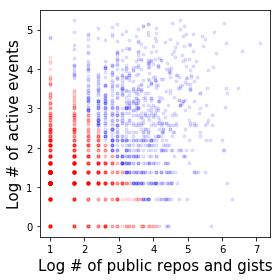

In [19]:
fsize=15
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
fig.set_tight_layout(True)
nusers=2000
ax.plot(predictions_df[:nusers].public_repos_gists.values[predictions_df[:nusers].high_low_user.values == 0], 
        predictions_df[:nusers].non_passive_events.values[predictions_df[:nusers].high_low_user.values == 0], 
               'r.', alpha=0.1)

ax.plot(predictions_df[:nusers].public_repos_gists.values[predictions_df[:nusers].high_low_user.values == 1], 
        predictions_df[:nusers].non_passive_events.values[predictions_df[:nusers].high_low_user.values == 1], 
               'b.', alpha=0.1)

ax.set_xlabel('Log # of public repos and gists', fontsize=fsize)
ax.set_ylabel('Log # of active events', fontsize=fsize)

fig.savefig('figures/Kmeans_clustering.png')

In [ ]:
print('{0}% labels == 0'.format(np.round(np.sum(
    predictions_df.prediction == 0) / len(predictions_df.prediction) * 100, 2)))